# Heart Disease Classification Project

This notebook implements a comprehensive analysis and classification of heart disease data using multiple machine learning approaches.

In [11]:
import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*", category=FutureWarning)

## Dataset Description

The Heart Disease dataset dates from 1988 and consists of four databases: Cleveland, Hungary, Switzerland, and Long Beach V. It contains 76 attributes, including the predicted attribute, but all published experiments refer to using a subset of 14 of them. The "target" field refers to the presence of heart disease in the patient. It is integer valued 0 = no disease and 1 = disease.

source: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

Here are the features:

1. **age**: Age in years

2. **sex**: Sex (1 = male, 0 = female)
3. **cp**: Chest pain type
   - Value 0: Typical angina
   - Value 1: Atypical angina
   - Value 2: Non-anginal pain
   - Value 3: Asymptomatic
4. **trestbps**: Resting blood pressure (in mm Hg)
5. **chol**: Serum cholesterol in mg/dl
6. **fbs**: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. **restecg**: Resting electrocardiographic results
   - Value 0: Normal
   - Value 1: Having ST-T wave abnormality
   - Value 2: Showing probable or definite left ventricular hypertrophy
8. **thalach**: Maximum heart rate achieved
9. **exang**: Exercise induced angina (1 = yes; 0 = no)
10. **oldpeak**: ST depression induced by exercise relative to rest
11. **slope**: The slope of the peak exercise ST segment
   - Value 0: Downsloping
   - Value 1: Flat (horizontal)
   - Value 2: Upsloping
12. **ca**: Number of major vessels colored by fluoroscopy (0-3)
13. **thal**: Thalassemia
   - Value 1: Normal
   - Value 2: Fixed defect
   - Value 3: Reversible defect
14. **target**: Diagnosis of heart disease (0 = absence, 1 = presence)

The names and social security numbers of the patients were recently removed from the database, replaced with dummy values.

## Setup and Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Configure visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
%matplotlib inline

# igore FutureWarning where calling sort_value
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Loading the Dataset

In [13]:
# Load the dataset
df = pd.read_csv('heart.csv')

## 2. Exploratory Data Analysis and Data Preprocessing

Let's examine and clean our dataset:

### 2.1 Initial Data Overview

In [ ]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

print("\nFirst few rows:")
df.head()

In [ ]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Find unique values for each column
len_unique = {}
for col in df.columns:
    len_unique[col]=len(df[col].unique())
print("\nUnique values for each column:", len_unique)

# Display basic statistics
print("\nBasic statistics:")
df.describe()

**The initial data exploration reveals:**
- Dataset shape: 1025 rows × 14 columns
- No missing values in any columns
- 723 duplicate rows identified
- Features include both continuous measurements (age, blood pressure, cholesterol) and categorical variables (sex, chest pain type)

### 2.2 Target Variable Distribution

In [ ]:
# Distribution of target variable
print(f"Proportion of positive cases: {len(df[df['target'] == 1]) / len(df):.2%}")

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.countplot(data=df, x='target')
plt.title('Distribution of Heart Disease')
plt.show()

**The target variable visualization shows:**
- Binary classification problem (0 = no heart disease, 1 = heart disease present)
- Nearly balanced dataset with approximately 51.3% positive cases
- Distribution plot indicates good representation of both classes, which is beneficial for model training

### 2.3 Age and Gender Analysis

In [ ]:
plt.figure(figsize=(15, 6))

# Age distribution by target
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='target', y='age')
plt.title('Age Distribution by Heart Disease')
plt.xlabel('Heart Disease Present')
plt.ylabel('Age')

# Age distribution by target and gender
sex_counts = df['sex'].value_counts(normalize=True) * 100
print("Percentage of male: {:.2f}%".format(sex_counts[1]), 
      "| Percentage of female: {:.2f}%".format(sex_counts[0]))

plt.subplot(1, 2, 2)
ax = sns.boxplot(data=df, x='target', y='age', hue='sex', palette=['pink', 'lightblue'])
plt.title('Age Distribution by Target and Gender')
plt.xlabel('Heart Disease Present')
plt.ylabel('Age')

# Create custom legend handles
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='pink', label='Female'),
                  Patch(facecolor='lightblue', label='Male')]

# Add the custom legend
plt.legend(handles=legend_elements, title='Gender')
plt.show()

**The age distribution plots reveal:**

The dataset skews male (about 70% male and 30& female).

**Patients with heart disease (target=1) do tend to be slightly younger on average** than those without. When we break it down by gender, we also see that:

-   **Men who have heart disease** present at **younger ages** (their median age is lower) than **women who have heart disease.**
-   Conversely, among those without heart disease, men again trend slightly younger than women, though the gap is smaller.

This suggests a **possible earlier onset** (or earlier detection) of heart disease in men, whereas women who develop heart disease in this dataset are often older.

### 2.4 Clinical Features Analysis

In [ ]:
# Clinical features distribution
clinical_features = ['trestbps', 'chol', 'thalach', 'oldpeak']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(clinical_features):
    sns.boxplot(data=df, x='target', y=feature, ax=axes[idx])
    axes[idx].set_title(f'{feature} by Target')

plt.show()

**Analysis of key clinical measurements:**
-   **Resting Blood Pressure (`trestbps`)**: The median resting blood pressure is **almost the same as patients without disease**, though there are outliers with very high BP in both groups. Overall, resting BP does not appear to differ strongly by disease status in this sample.

-   **Cholesterol (`chol`)**: CBoth groups show substantial overlap (and some extreme outliers ≥ 500 mg/dl), with only a small difference in the median levels. This suggests cholesterol alone may not be a highly discriminative feature in this particular dataset.

-   **Maximum Heart Rate (`thalach`)**: The “Disease” group shows a higher median and overall distribution for maximum achieved heart rate compared to the no‐disease group. While it may seem counterintuitive (as one might expect limited heart‐rate response in more diseased hearts), in this dataset higher max‐HR measurements appear associated with having heart disease—likely reflecting the presence of individuals who can mount a stress response but still manifest other disease indicators.

-   **ST Depression (`oldpeak`)**: Those **without disease** have a **higher median** ST depression, whereas patients with disease often show lower ST depression---though the "no disease" group has considerable variability and a number of outliers.

### 2.5 Medical Risk Factors

In [ ]:
# Analyze key risk factors
risk_factors = ['cp','fbs', 'exang', 'slope', 'ca', 'thal']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, factor in enumerate(risk_factors):
    sns.countplot(data=df, x=factor, hue='target', ax=axes[idx])
    axes[idx].set_title(f'{factor} Distribution by Target')
    axes[idx].legend(['No Disease', 'Disease'])

plt.show()

**Categorical risk factors show distinct patterns:**
- **Chest Pain Type (`cp`)**: **Typical angina (CP=0)** appears to be most prevalent among the no‐disease group, while atypical angina (CP=1), non‐anginal pain (CP=2), and asymptomatic presentations (CP=3) tend to be more common in the group that does have heart disease with **non-anginal pain** being most common in those with disease.

- **Fasting Blood Sugar (`fbs`)**: The vast majority of both groups have a **normal fasting blood sugar (fbs=0).** A smaller share of each group shows elevated blood sugar (fbs=1).

-   **Exercise-Induced Angina (`exang`)**: Having *no* exercise-induced angina (exang=0) is **more frequent** among those **with heart disease**; by contrast, exang=1 appears more in the no‐disease group.

-   **Slope of ST Segment (`slope`)**: A **downsloping ST segment (slope=0)** is more associated with those who **do not have heart disease**, whereas an **upsloping ST segment (slope=2)** is much more common among disease‐positive individuals. **Flat ST slope (slope=2)** is present much more often in the no disease group vs those with disease but has a higher proportion of those with disease compared to slope 0.

-   **Number of Major Vessels (`ca`)**: A large fraction of those **with disease** have **0 major vessels** colored by fluoroscopy, while those with **1 or more** vessels colored tend to be more in the no‐disease group.

-   **Thalassemia Status (`thal`)**: "Reversible defect" (thal=3) occurs more often in the no disease group, along with "normal" (thal=1). "Fixed defect" (thal=2) occurs often in people with disease.

### 2.6 Feature Correlations

In [ ]:
# Calculate feature correlations with target
correlations = df.corr()['target'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
correlations.plot(kind='bar')
plt.title('Feature Correlations with Target')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### **Correlation Analysis:**

#### **Key Correlations with the target (Heart Disease):**
1. **Chest Pain Type (cp)** → *0.43*
   - Moderate positive correlation
   - Certain chest pain types indicate higher likelihood of heart disease
   - Significant diagnostic indicator

2. **Maximum Heart Rate (thalach)** → *0.42*
   - Moderate positive correlation
   - Higher exercise heart rates linked to increased disease probability

3. **ST Segment Slope (slope)** → *0.35*
   - Moderate positive correlation
   - Steeper slopes during peak exercise associated with heart disease

4. **Exercise-Induced Angina (exang)** → *-0.44*
   - Moderate negative correlation
   - Counterintuitive finding: exercise-induced chest pain linked to lower disease probability
   - May indicate data imbalance or specific dataset patterns

5. **ST Depression (oldpeak)** → *-0.44*
   - Moderate negative correlation
   - Unexpected finding: greater ST depression linked to lower disease risk
   - Requires further clinical investigation

6. **Number of Major Vessels (ca)** → *-0.38*
   - Moderate negative correlation
   - Unusual finding: more blocked vessels associated with lower risk
   - Possible feature misinterpretation

7. **Thalassemia (thal)** → *-0.34*
   - Moderate negative correlation

8. **Sex** → *-0.28*
   - Males show slightly lower disease probability

9. **Age** → *-0.23*
   - Unexpected negative correlation with age
   - Warrants further investigation

#### **Notable Feature-to-Feature Correlations:**

1. **oldpeak → slope**: *-0.58*
  - Strong negative correlation between ST depression and slope

2. **cp → exang**: *-0.40*
  - Inverse relationship between chest pain types and exercise-induced angina

3. **exang → thalach**: *-0.38*
  - Exercise-induced angina associated with lower max heart rates

4. **cp → thalach**: *0.31*
  - Certain chest pain types correlate with higher exercise heart rates

#### **Summary of Strongest Correlations**

##### Positive Correlations with Heart Disease
- Chest pain type (cp)
- Maximum heart rate (thalach)
- ST Segment Slope (slope)

##### Negative Correlations with Heart Disease
- ST depression (oldpeak)
- Exercise induced angina (exang)
- Number of vessels (ca)

### 2.7 Data Preprocessing

In [21]:
# Define preprocessing functions

# Function to remove outliers using IQR method
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Identify numerical and categorical columns
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['cp', 'thal', 'slope', 'restecg']

In [ ]:
# Data cleaning and feature engineering

# Handle outliers in numerical features
df_clean = remove_outliers(df, numerical_features)
print(f"Rows after outlier removal: {len(df_clean)} (removed {len(df) - len(df_clean)} rows)")

# Separate features and target
X = df_clean.drop('target', axis=1)
y = df_clean['target']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_features)

In [ ]:
# Train/test split and scaling

# Split the data
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Scale only the numerical features
scaler = StandardScaler()
X_train = X_train_unscaled.copy()
X_test = X_test_unscaled.copy()
X_train[numerical_features] = scaler.fit_transform(X_train_unscaled[numerical_features])
X_test[numerical_features] = scaler.transform(X_test_unscaled[numerical_features])

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nFeatures after one-hot encoding:", X_train.columns.tolist())

## 3. Feature Selection

In [47]:
import importlib
import Feature_selection
importlib.reload(Feature_selection)
from Feature_selection import autoFeatureSelector

#### Find best features

In [ ]:
# `num_output_features` specifies the number of features to select for each method.
# The `autoFeatureSelector` function applies multiple feature selection methods 
# (e.g., Pearson correlation, chi-square test, RFE, etc.) and combines their results
# by voting to identify the most important features.

best_features = autoFeatureSelector(
    X,
    y,
    methods=['pearson', 'chi-square', 'rfe', 'log-reg', 'rf', 'lgbm'],  # List of feature selection methods
    num_output_features=5  # Number of features to select per method
)

# Output the final list of selected features after voting
best_features

In [ ]:
X_fs = X[['oldpeak', 'thalach', 'cp', 'ca', 'thal']]
X_fs = pd.get_dummies(X_fs, columns=['thal', 'cp'])
X_fs.head()

## 4. Models

### 4. Stochastic Gradient Descent (SGD)

In [105]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Initialize both models
sgd_default = SGDClassifier(random_state=42)

# Train both models
sgd_default.fit(X_train, y_train)

In [120]:
# Make predictions for both models
y_pred_default = sgd_default.predict(X_test)

In [ ]:
# Compare model performances
print("Default SGD Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_default))
print("\nClassification Report:\n", classification_report(y_test, y_pred_default))


# Compare confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for default model
sns.heatmap(confusion_matrix(y_test, y_pred_default), 
            annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Default SGD Confusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

In [ ]:
# Cross-validation analysis
from sklearn.model_selection import cross_val_score, learning_curve

# Perform cross-validation
cv_scores = cross_val_score(sgd_model, X_train, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print(f"Mean CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    sgd_model, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, n_jobs=-1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves for SGD Classifier')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
# Define hyperparameter grid for tuning
param_grid = {
    'loss': ['modified_huber', 'log_loss'],          # Focus on probability-calibrated losses
    'penalty': ['l2', 'elasticnet'],                # Regularization methods
    'alpha': [0.0001, 0.001],                       # Lower regularization for better recall
    'learning_rate': ['adaptive'],                  # Adaptive learning rate
    'eta0': [0.01, 0.1],                           # Initial learning rate
    'class_weight': [{0:1, 1:2}, {0:1, 1:3}]       # Try different false negative penalties
}

# Perform grid search optimizing for recall
grid_search = GridSearchCV(SGDClassifier(random_state=42, 
                                       max_iter=1000, 
                                       tol=1e-3,
                                       early_stopping=True,
                                       validation_fraction=0.1),
                           param_grid,
                           scoring='recall',  # Optimize for minimizing false negatives
                           cv=5,
                           verbose=2)

grid_search.fit(X_train, y_train)


Best Parameters Found: {'alpha': 0.0001, 'class_weight': {0: 1, 1: 3}, 'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'penalty': 'l2'}

Baseline SGD Model Metrics:
---------------------------
Accuracy: 0.8448275862068966

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       144
           1       0.85      0.84      0.85       146

    accuracy                           0.84       290
   macro avg       0.84      0.84      0.84       290
weighted avg       0.84      0.84      0.84       290


Tuned SGD Model Metrics:
------------------------
Accuracy: 0.8241379310344827

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       144
           1       0.77      0.94      0.84       146

    accuracy                           0.82       290
   macro avg       0.84      0.82      0.82       290
weighted avg       0.84      

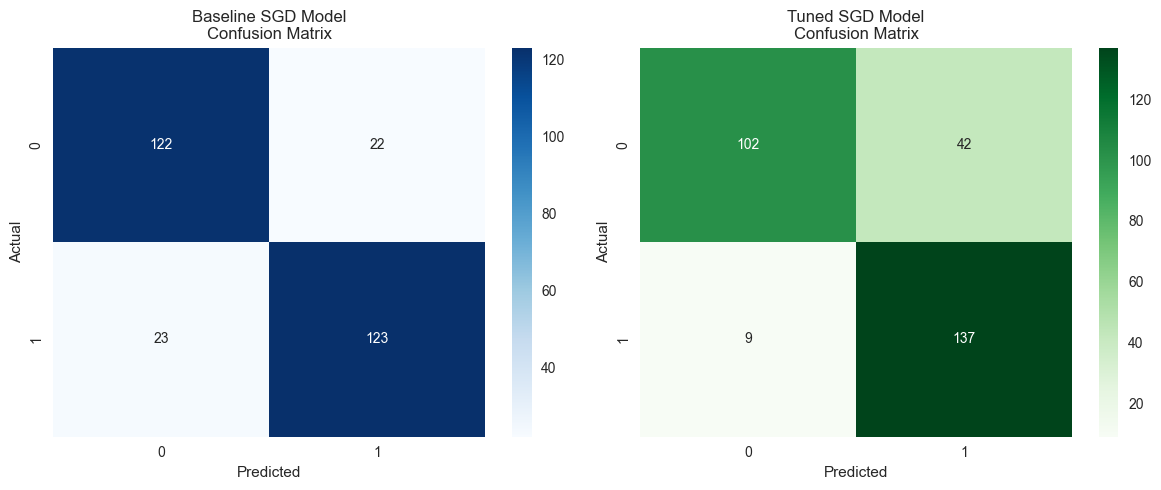

In [131]:
# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("\nBest Parameters Found:", best_params)

# Compare baseline and tuned model metrics
print("\nBaseline SGD Model Metrics:")
print("---------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred_default))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_default))

print("\nTuned SGD Model Metrics:")
print("------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Baseline model confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_default), 
            annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title("Baseline SGD Model\nConfusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

# Tuned model confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_tuned),
            annot=True, fmt="d", cmap="Greens", ax=ax2)
ax2.set_title("Tuned SGD Model\nConfusion Matrix") 
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [39]:
#Feature Removal and Re-Evaluation
#Randomly or strategically remove features to observe how it impacts model performance.


In [40]:
# Remove a subset of features (e.g., drop the 'chol' and 'thalach' columns)
X_train_reduced = X_train.drop(['chol', 'thalach'], axis=1)
X_test_reduced = X_test.drop(['chol', 'thalach'], axis=1)

In [ ]:
# Retrain the SGD model with reduced features
sgd_model_reduced = SGDClassifier(random_state=42)
sgd_model_reduced.fit(X_train_reduced, y_train)

In [ ]:
# Evaluate the reduced model
y_pred_reduced = sgd_model_reduced.predict(X_test_reduced)
print("\nSGD Classifier Results (Reduced Features):")
print("Accuracy:", accuracy_score(y_test, y_pred_reduced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_reduced))

In [ ]:
# Confusion matrix for the reduced model
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_reduced), annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.title("Confusion Matrix (Reduced Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Random Forest

**Baseline Model (No Feature Selection, No Hyperparameter Tuning)** 

In [ ]:
rf_model_base = RandomForestClassifier()
rf_model_base.fit(X_train, y_train)

In [37]:
y_pred_base = rf_model_base.predict(X_test)

In [ ]:
accuracy_base = accuracy_score(y_test, y_pred_base)
print(f'Accuracy: {accuracy_base}')

**Baseline with Hyperparamaters Tuning (No Feature Selection, with GridSearchCV)**

In [39]:
param_grid = {
    'n_estimators': [100, 300, 500],  
    'max_depth': [2, 3, 5],  
    'min_samples_split': [2, 10, 20],  
    'min_samples_leaf': [1, 5, 10],  
    'max_features': ['sqrt', 'log2']  
}

In [ ]:
rf_model_base_tuned = GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    cv = 5, 
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 1
)

rf_model_base_tuned.fit(X_train, y_train)

In [ ]:
rf_model_base_tuned.best_params_

In [42]:
y_pred_base_tuned = rf_model_base_tuned.best_estimator_.predict(X_test)

In [ ]:
accuracy_base_tuned = accuracy_score(y_test, y_pred_base_tuned)
print(f'Accuracy: {accuracy_base_tuned}')

**Feature-Selected Model (With Feature Selection, No GridSearchCV)**

In [ ]:
rf_model_fs = RandomForestClassifier()
rf_model_fs.fit(X_train_fs, y_train_fs)

In [45]:
y_pred_fs = rf_model_fs.predict(X_test_fs)

In [ ]:
accuracy_fs = accuracy_score(y_test_fs, y_pred_fs)
print(f'Accuracy: {accuracy_fs}')

**Feature-Selected with Hyperparameter Tuning (With Feature Selection, With GridSearchCV)**

In [ ]:
rf_model_fs_tuned = GridSearchCV(
    RandomForestClassifier(), 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs = -1, 
    verbose = 1
)

rf_model_fs_tuned.fit(X_train_fs, y_train_fs)

In [ ]:
rf_model_fs_tuned.best_params_

In [49]:
y_pred_fs_tuned = rf_model_fs_tuned.best_estimator_.predict(X_test_fs)

In [ ]:
accuracy_fs_tuned = accuracy_score(y_test_fs, y_pred_fs_tuned)
print(f'Accuracy: {accuracy_fs_tuned}')

**Confusion Matrix**

In [ ]:
# Generate predictions for 4 different models
y_pred_1 = rf_model_base.predict(X_test)         # Model 1: Clean data, no feature selection
y_pred_2 = rf_model_base_tuned.best_estimator_.predict(X_test)   # Model 2: Clean data, no feature selection, with GridSearchCV
y_pred_3 = rf_model_fs.predict(X_test_fs)           # Model 3: Clean data, with feature selection
y_pred_4 = rf_model_fs_tuned.best_estimator_.predict(X_test_fs)    # Model 4: Clean data, feature selection, with GridSearchCV

# Compute confusion matrices
cm_1 = confusion_matrix(y_test, y_pred_base)
cm_2 = confusion_matrix(y_test, y_pred_base_tuned)
cm_3 = confusion_matrix(y_test, y_pred_fs)
cm_4 = confusion_matrix(y_test, y_pred_fs_tuned)

# Create subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Define model names for better visualization
titles = [
    "Model 1: Baseline (No FS, No GridSearch)",
    "Model 2: Baseline (No FS, With GridSearch)",
    "Model 3: With Feature Selection (No GridSearch)",
    "Model 4: With Feature Selection (With GridSearch)"
]

# Function to plot confusion matrix using seaborn heatmap
def plot_confusion_matrix(ax, cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"], ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

# Plot all four confusion matrices
for ax, cm, title in zip(axes.ravel(), [cm_1, cm_2, cm_3, cm_4], titles):
    plot_confusion_matrix(ax, cm, title)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

### **Conclusion on Model Performance and Overfitting**

1. **Overfitting in the Baseline Models**
   - **Before Feature Selection (Model 1 & Model 2)**
     - Model 1 (Baseline, No FS, No GridSearch) achieves perfect classification:
       - True Positives (TP): 146
       - True Negatives (TN): 144
       - No misclassifications (0 FP, 0 FN).
       - This suggests the model might be overfitting, as perfect accuracy on a real-world dataset is uncommon.
     - Model 2 (Baseline, No FS, With GridSearch) introduces misclassifications:
       - FP increases to 16, FN increases to 11.
       - A slight drop in accuracy, indicating that GridSearchCV might be tuning hyperparameters in a way that reduces overfitting.

2. **Feature Selection Impacts Generalization**
   - **After Feature Selection (Model 3 & Model 4)**
     - Model 3 (With Feature Selection, No GridSearch):
       - FP: 9, FN: 22.
       - More misclassifications compared to Model 1.
       - While accuracy decreases slightly, this indicates better generalization, as the model is no longer memorizing the dataset.
     - Model 4 (With Feature Selection, With GridSearch):
       - FP increases to 30, FN decreases to 20.
       - This suggests that hyperparameter tuning, specifically adjusting **max_depth**, helps control overfitting and improves the model's ability to perform well on unseen data.

### **Key Takeaways**
- **Baseline Model 1 exhibits possible overfitting** (perfect accuracy).
- **Feature selection improves generalization but introduces more misclassifications** (Models 3 & 4).
- **GridSearchCV helps prevent overfitting** by tuning parameters like **max_depth**, leading to better generalization.

# Support Vector Machine

## SVC Baseline

In [ ]:
svc_base = SVC(random_state=42)
svc_base.fit(X_train, y_train)

In [ ]:
y_pred_train_svc_base = svc_base.predict(X_train)
y_pred_svc_base = svc_base.predict(X_test)
confusion_matrix(y_test, y_pred_svc_base)

In [ ]:
training_accuracy_svc_base = accuracy_score(y_train, y_pred_train_svc_base)
test_accuracy_svc_base = accuracy_score(y_test, y_pred_svc_base)
print("SVC baseline training dataset accuracy score", training_accuracy_svc_base)
print("SVC baseline testing dataset accuracy score", test_accuracy_svc_base)

## SVC Base Model Grid Search

In [55]:
svc_param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['rbf']
}

In [ ]:
svc_grid = GridSearchCV(SVC(), svc_param_grid, refit=True, verbose=3)  # refits the estimator using the best found parameters
svc_grid.fit(X_train, y_train)

In [ ]:
svc_grid_predictions = svc_grid.predict(X_test)
confusion_matrix(y_test, svc_grid_predictions)

In [ ]:
accuracy_score(y_test, svc_grid_predictions)

In [ ]:
svc_grid.best_estimator_

In [ ]:
svc_grid.best_params_

## SVC Feature-Selected Model

In [ ]:
svc_fs = SVC(random_state=42)
svc_fs.fit(X_train_fs, y_train_fs)
y_predict_train_svc_fs = svc_fs.predict(X_train_fs)
y_predict_test_svc_fs = svc_fs.predict(X_test_fs)
accuracy_train_svc_fs = accuracy_score(y_train_fs, y_predict_train_svc_fs)
accuracy_test_svc_fs = accuracy_score(y_test_fs, y_predict_test_svc_fs)
print("SVC feature selected train dataset accuracy score:", accuracy_train_svc_fs)
print("SVC feature selected test dataset accuracy score:", accuracy_test_svc_fs)

## SVC Feature-Selected Hyperparameter tuned

In [ ]:
svc_fs_grid = GridSearchCV(SVC(), svc_param_grid, refit=True, verbose=3)  # refits the estimator using the best found parameters
svc_fs_grid.fit(X_train_fs, y_train_fs)
y_predict_train_svc_fs_grid = svc_fs_grid.predict(X_train_fs)
y_predict_test_svc_fs_grid = svc_fs_grid.predict(X_test_fs)

In [ ]:
accuracy_train_svc_fs_grid = accuracy_score(y_train_fs, y_predict_train_svc_fs_grid)
accuracy_test_svc_fs_grid = accuracy_score(y_test_fs, y_predict_test_svc_fs_grid)
print("SVC feature selected TUNED train dataset accuracy score:", accuracy_train_svc_fs_grid)
print("SVC feature selected TUNED test dataset accuracy score:", accuracy_test_svc_fs_grid)

In [ ]:
confusion_matrix(y_test_fs, y_predict_test_svc_fs_grid)